In [8]:
import models
import os
import torch
from torch import optim, nn
from torchvision import transforms, datasets, io
import torchvision
import common
import matplotlib.pyplot as plot_hw1
from PIL import Image

i=[]
j=[]
dict_plot = {}

In [2]:
#DIRECTORY SETTINGS
os.chdir("..")#Go up two directories
SAVE_DIR = '/home/sskulka/models'
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, '/home/sskulka/models/base.pt')
#MODEL_SAVE_PATH = '/home/sskulka/base.pt'

#HYPERPARAMETERS
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
EPOCHS=100
BATCH_SIZE = 64
criterion = nn.CrossEntropyLoss()
ADAM_OPTIMISER=True
LEARNING_RATE=0.001

cuda


In [3]:
train_transforms = transforms.Compose([# Data Transforms
                           transforms.Resize(256),#Resize
                           transforms.RandomHorizontalFlip(30),#Flip
                           transforms.RandomRotation(10),#Roatate
                           transforms.RandomCrop(256),#Crop
                           transforms.ToTensor(),#Convert to Tensor
                           transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))#Normalize
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
                       ])

In [4]:
train_data = torchvision.datasets.CIFAR10(root='/home/sskulka/data', train=True, download=True, transform=train_transforms)#Use CIFAR10 to train
train_data, valid_data = torch.utils.data.random_split(train_data, [int(len(train_data)*0.9), len(train_data) - int(len(train_data)*0.9)])
test_data = torchvision.datasets.CIFAR10(root='/home/sskulka/data', train=False, download=True, transform=test_transforms)


print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')


train_iterator = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_iterator = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified
Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


In [5]:
model = torchvision.models.resnet18(pretrained=True)#TorchVision
#Using multiple gpus
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")

for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)

#model = nn.DataParallel(model).cuda()

#Hyperparameters
if(ADAM_OPTIMISER):
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
else:
    optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.5)

Let's use 2 GPUs!


In [6]:
#Train
best_valid_loss = float('inf')
for epoch in range(EPOCHS):#Range of Epochs
    print(epoch)
    train_loss, train_acc = common.train(model, device, train_iterator, optimizer, criterion)#Train Loss Calculation
    valid_loss, valid_acc = common.evaluate(model, device, valid_iterator, criterion)#Validation Loss Calculation

    if valid_loss < best_valid_loss:#Validation Loss - Is current lower than the saved validation loss.
        best_valid_loss = valid_loss#Save the best loss (lowest)
        torch.save(model.state_dict(), MODEL_SAVE_PATH)#Save the model

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:05.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:05.2f}% |')


0
| Epoch: 01 | Train Loss: 1.039 | Train Acc: 66.46% | Val. Loss: 0.795 | Val. Acc: 73.64% |
1
| Epoch: 02 | Train Loss: 0.776 | Train Acc: 73.61% | Val. Loss: 0.741 | Val. Acc: 74.45% |
2
| Epoch: 03 | Train Loss: 0.734 | Train Acc: 74.65% | Val. Loss: 0.706 | Val. Acc: 75.65% |
3
| Epoch: 04 | Train Loss: 0.717 | Train Acc: 75.47% | Val. Loss: 0.704 | Val. Acc: 75.53% |
4
| Epoch: 05 | Train Loss: 0.698 | Train Acc: 75.77% | Val. Loss: 0.680 | Val. Acc: 76.33% |
5
| Epoch: 06 | Train Loss: 0.690 | Train Acc: 76.13% | Val. Loss: 0.656 | Val. Acc: 77.75% |
6
| Epoch: 07 | Train Loss: 0.685 | Train Acc: 76.46% | Val. Loss: 0.668 | Val. Acc: 76.80% |
7
| Epoch: 08 | Train Loss: 0.681 | Train Acc: 76.42% | Val. Loss: 0.658 | Val. Acc: 76.15% |
8
| Epoch: 09 | Train Loss: 0.677 | Train Acc: 76.55% | Val. Loss: 0.668 | Val. Acc: 76.98% |
9
| Epoch: 10 | Train Loss: 0.672 | Train Acc: 76.77% | Val. Loss: 0.664 | Val. Acc: 76.84% |
10
| Epoch: 11 | Train Loss: 0.668 | Train Acc: 77.06% | Val

In [32]:
#Image
horse1 = torchvision.io.read_image(str('/home/sskulka/HW1/horse4.jpg'))/255
#3d RGB Tensor
plot_hw1.show([horse1])
print(horse1)

infer_transforms = transforms.Compose([torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])
#need to understand normalize further- https://sparrow.dev/pytorch-normalize/

horse1 = infer_transforms(horse1).float()
#horse1 = infer_transforms(horse1)

horse1 = torch.tensor(horse1, requires_grad=True)
horse1 = horse1.unsqueeze(0)

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


/local_scratch/pbs.3482657.pbs02/ipykernel_956616/3921781527.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  horse1 = torch.tensor(horse1, requires_grad=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse
| Test Loss: 0.635 | Test Acc: 78.05%


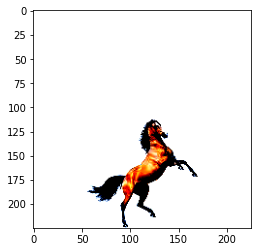

In [33]:
#3. OUTPUT
#model = torchvision.models.resnet18(pretrained=True)#TorchVision
#model=model.cuda()
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

model.load_state_dict(torch.load(MODEL_SAVE_PATH)) #Load best weights from file

horse1 = horse1.cuda()

model = model.to(device)
model.eval()
output=model(horse1)
predict_value,predict_idx = torch.max(output,1)
plot_hw1.imshow(horse1[0].permute(1,2,0).clone().detach().cpu().numpy())
#print(train_data.classes[predict_idx])
print(classes[predict_idx])

test_loss, test_acc = common.evaluate(model, device, valid_iterator, criterion) #Test Loss is dependent on
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:05.2f}%')